In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

2023-09-04 17:32:27.367461: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-04 17:32:28.041302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-04 17:32:28.041387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-04 17:32:28.041394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_wav_16k_mono(filename):
    # load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # remove trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # goes from 44100hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
POS = os.path.join('Parsed_Capuchinbird_Clips')
NEG = os.path.join('Parsed_Not_Capuchinbird_Clips')

In [5]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [6]:
len(neg)

593

In [7]:
from numpy import positive
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [8]:
lengths = []
for file in os.listdir(os.path.join('Parsed_Capuchinbird_Clips')):
    if file == '.ipynb_checkpoints':
        continue
    tensor_wave = load_wav_16k_mono(os.path.join('Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

2023-09-04 17:32:47.812569: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


In [9]:
len(lengths)

217

In [10]:
# Build prepocessing function
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [11]:
# create a tensorflow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [12]:
train = data.take(36)
test = data.take(36).take(15)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [14]:
# Buid Sequential Model, Compile and View Summary
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('Adam', loss="BinaryCrossentropy", metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2023-09-04 17:33:41.456711: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-04 17:33:41.456764: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


36/36 [==============================] - 32s 308ms/step - loss: 11.8777 - recall: 0.8333 - precision: 0.7714 - val_loss: 0.1579 - val_recall: 1.0000 - val_precision: 0.9474
Epoch 2/4
36/36 [==============================] - 11s 301ms/step - loss: 0.1916 - recall: 0.9610 - precision: 0.9308 - val_loss: 0.0250 - val_recall: 0.9839 - val_precision: 0.9839
Epoch 3/4
36/36 [==============================] - 11s 302ms/step - loss: 0.0684 - recall: 0.9814 - precision: 0.9753 - val_loss: 0.0157 - val_recall: 0.9839 - val_precision: 0.9839
Epoch 4/4
36/36 [==============================] - 11s 302ms/step - loss: 0.0410 - recall: 0.9935 - precision: 0.9686 - val_loss: 0.0049 - val_recall: 1.0000 - val_precision: 1.0000


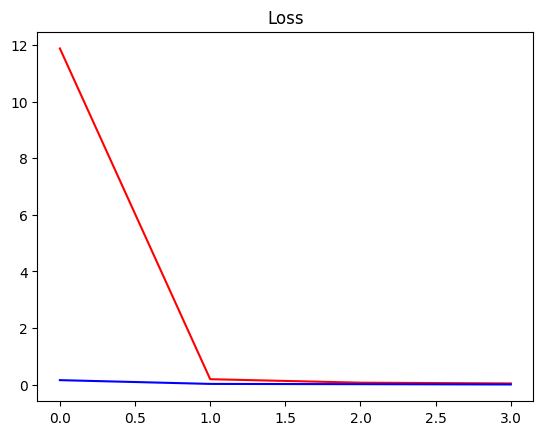

In [18]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

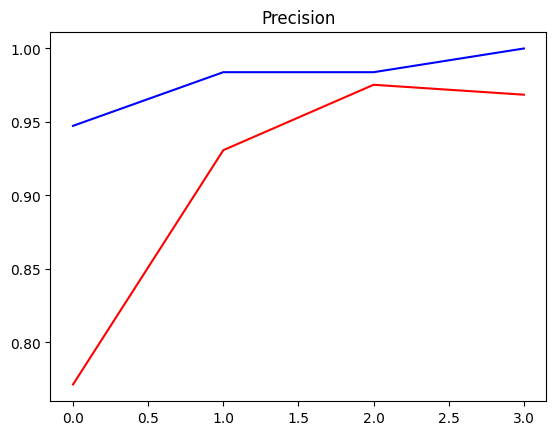

In [19]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

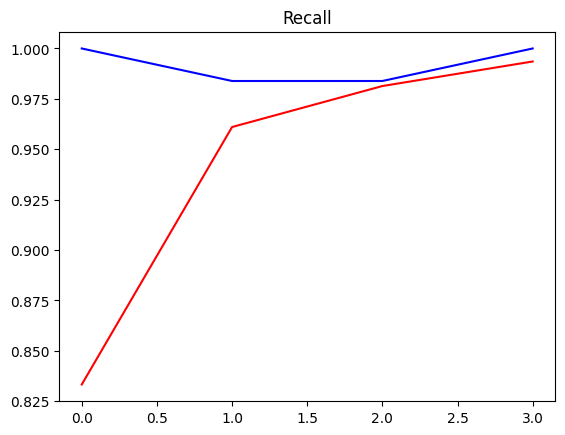

In [20]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [21]:
# Make a prediction on a single clip

In [22]:
X_test, y_test = test.as_numpy_iterator().next()

In [23]:
X_test.shape

(16, 1491, 257, 1)

In [24]:
y_test.shape

(16,)

In [26]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 100ms/step


In [27]:
yhat

array([[9.99999642e-01],
       [5.82964687e-19],
       [1.00000000e+00],
       [8.75168841e-15],
       [6.22366210e-21],
       [1.00000000e+00],
       [5.54080345e-02],
       [1.22962765e-10],
       [1.93273418e-11],
       [5.20196064e-09],
       [7.56337423e-11],
       [1.37749541e-22],
       [5.48851416e-02],
       [1.28605820e-10],
       [1.10879885e-26],
       [0.00000000e+00]], dtype=float32)

In [33]:
yhat = [ 1 if prediction > 0.99 else 0 for prediction in yhat]

In [34]:
yhat

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

## Build forest parsing functions

In [31]:
# load up mp3s
def load_mp3_16k_mono(filename):
    """ load a wav file, convert it to a float tensor, resample
    to 16khz single-channel audio.
    """
    res = tfio.audio.AudioIOTensor(filename)
    # convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # extract sample rate and cost
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # resample to 16 khz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [32]:
mp3 = os.path.join('Forest Recordings')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_l

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()